# Technical Indicators Model

## 1) Introduction

Stock price movement can be predicted using a variety of technical indicators. As we would like to be able to predict whether or not we should buy or sell a stock at a certain time, we could therefore turn to technical indicators to aid us in deciding whether or not buy or sell a stock. 

For this project, we will be using data on historical stock prices and 3 main technical indicators, namely the Simple Moving Average, Exponential Moving Average and Moving Average Convergence/Divergence, to build a machine learning model that can utilise technical indicators to classify 3 types of signals, namely the buy, hold and sell signals.

With this model, one could estimate the best times to buy or sell a stock, and hence gain more returns from the market trading AAPL stock.

### Overview:
- Data Preprocessing
    - In this stage, we will remove any redundant columns which might add unneccessary noise to our dataset. We will also ensure all the data is of appropriate data types and ensure no values are missing. In addition, we will also conduct an analysis of our dataset to observe and determine any possible trends in our dataset, as well as create new columns that could be useful in helping us determining buy and sell signals. These would be helpful in ensuring that our machine learning model can be trained effectively and generate accurate buy and sell signals
- Methodology and Experiments
    - In this section, we would train and test a machine learning model using the technical indicators data that we have obtained via preprocessing. From there, we will be able to identify which variable is the most effective at accurately classifying buy, hold and sell signals, and we would then be able experiment with different types of classification models
    - We would also measure their effectiveness using classification metrics such that Accuracy, True Positive Rate, True Negative Rate etc.,  which will allow us to compare the different models we have built and determine the model that is most effective in generating buy and sell signals
- Conclusion
    - Lastly, we will summarize our findings in this project and determine any limitations and possible improvements we could make to our model.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from yahoo_fin import stock_info as sf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sb
sb.set()

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
random_state = 1

## 2) Data Preprocessing

The dataset we will be using for this problem will consist of the historical daily stock prices of AAPL, including the High, Low, Open, Close, Adjusted Close and Volume, as well as the date of each trading day and the stock ticker from 2017-03-01 to 2023-03-01.

- Data Description
    - date = Date of trading day
    - high = Maximum traded price of AAPL stock on that day
    - low = Minimum traded price of AAPL stock on that day
    - open = The first traded price of AAPL stock on that day
    - close = The last traded price of AAPL stock on that day
    - adjclose = Adjusted closing price of the day, after accounting for all applicable splits and dividend distributions
    - volume = Number of shares of AAPL stock traded on that day
    - ticker = AAPL stock symbol

In [2]:
stock = 'AAPL'
short_window = 20
medium_window = 50
start_date = '2015-01-01'
end_date = '2020-01-01'

### Get Stock Data

In [3]:
pre_start_date = dt.date.fromisoformat(start_date) - dt.timedelta(100)
stock_df = sf.get_data(ticker=stock, start_date=pre_start_date, end_date=end_date, index_as_date=False)
stock_df

,date,open,high,low,close,adjclose,volume,ticker
0,2014-09-23,25.150000,25.735001,25.135000,25.660000,22.962931,253608800,AAPL
1,2014-09-24,25.540001,25.712500,25.299999,25.437500,22.763823,240687200,AAPL
2,2014-09-25,25.127501,25.177500,24.430000,24.467501,21.895771,400368000,AAPL
3,2014-09-26,24.632500,25.187500,24.600000,25.187500,22.540094,249482000,AAPL
4,2014-09-29,24.662500,25.110001,24.657499,25.027500,22.396915,199065200,AAPL
...,...,...,...,...,...,...,...,...
1323,2019-12-24,71.172501,71.222504,70.730003,71.067497,69.517075,48478800,AAPL
1324,2019-12-26,71.205002,72.495003,71.175003,72.477501,70.896324,93121200,AAPL
1325,2019-12-27,72.779999,73.492500,72.029999,72.449997,70.869423,146266000,AAPL
1326,2019-12-30,72.364998,73.172501,71.305000,72.879997,71.290047,144114400,AAPL


### Ensure Appropriate Data Types and Remove Unnecessary Noise
- We will include a column for the millisecond conversion of the date since timedate data is usually not supported by many machine learning models, thus having a strictly numeric millisecond column by converting the date to milliseconds would allow us a wider range of models
- The ticker column is a redundant column since every entry will be populated with the same value ('AAPL'), hence it might lead to unneccessary noise which could affect our model's accuracy in the future, hence we will remove it from the dataset

In [4]:
stock_df.insert(
    1, 
    'date_ms', 
    stock_df['date'].astype('int64') // (10 ** 9), 
    True
)
stock_df.drop(columns=['ticker'], inplace=True)
stock_df

,date,date_ms,open,high,low,close,adjclose,volume
0,2014-09-23,1411430400,25.150000,25.735001,25.135000,25.660000,22.962931,253608800
1,2014-09-24,1411516800,25.540001,25.712500,25.299999,25.437500,22.763823,240687200
2,2014-09-25,1411603200,25.127501,25.177500,24.430000,24.467501,21.895771,400368000
3,2014-09-26,1411689600,24.632500,25.187500,24.600000,25.187500,22.540094,249482000
4,2014-09-29,1411948800,24.662500,25.110001,24.657499,25.027500,22.396915,199065200
...,...,...,...,...,...,...,...,...
1323,2019-12-24,1577145600,71.172501,71.222504,70.730003,71.067497,69.517075,48478800
1324,2019-12-26,1577318400,71.205002,72.495003,71.175003,72.477501,70.896324,93121200
1325,2019-12-27,1577404800,72.779999,73.492500,72.029999,72.449997,70.869423,146266000
1326,2019-12-30,1577664000,72.364998,73.172501,71.305000,72.879997,71.290047,144114400


### Get Indicator Data
For this project, I would be focussing on short term (20 days) to medium term (50 days) investing or trading, and would have to identify appropriate buy or sell positions to maximize profits. Hence, I must calculate the short and medium term technical indicator data for the SMA, EMA and MACD.

- Columns that must be calculated and added
    - sma_20 = 20 day simple moving average of AAPL stock price on that day, calculated by taking the average of the closing price of AAPL stock over the past 20 days
    - sma_50 = 50 day simple moving average of AAPL stock price on that day, calculated by taking the average of the closing price of AAPL stock over the past 50 days
    - ema_20 = 20 day exponential moving average of AAPL stock price on that day, calculated by using the formula ema_20 = {today's closing price} X (2/21) + {previous day's closing price} X (1 - (2/21))
    - ema_50 = 50 day exponential moving average of AAPL stock price on that day, calculated by using the formula ema_50 = {today's closing price} X (2/51) + {previous day's closing price} X (1 - (2/51))
    - macd_value = Moving Average Convergence/Divergence value for AAPL stock on that day, calculated by subtracting the 26-day-EMA from the 12-day-EMA
    - macd_signal = Moving Average Convergence/Divergence signal for AAPL stock on that day, obtained from the 9 day exponential moving average of the macd_value for AAPL stock

In [5]:
def getIndicator(indicator, data):
    if indicator.lower() == 'sma':
        for window in [short_window, medium_window]:
            data[f'sma_{window}'] = data['close'].rolling(window).mean()
    elif indicator.lower() == 'ema':
        for window in [short_window, medium_window]:
            data[f'ema_{window}'] = data['close'].ewm(span=window).mean()
    elif indicator.lower() == 'macd':
        for window in [12, 26]:
            data[f'macd_{window}'] = data['close'].ewm(span=window).mean()
        data['macd_value'] = data['macd_12'] - data['macd_26']
        data.drop(labels=['macd_12', 'macd_26'], axis=1, inplace=True)
        data['macd_signal'] = data['macd_value'].ewm(span=9).mean()
    return pd.DataFrame(data)

In [6]:
stock_df = getIndicator('sma', stock_df)
stock_df = getIndicator('ema', stock_df)
stock_df = getIndicator('macd', stock_df)
stock_df = stock_df[50:].reset_index(drop=True)
stock_df.to_csv('AAPL_historical_data.csv')
stock_df

,date,date_ms,open,high,low,close,adjclose,volume,sma_20,sma_50,ema_20,ema_50,macd_value,macd_signal
0,2014-12-03,1417564800,28.937500,29.087500,28.777500,28.982500,26.048670,172253600,28.500625,26.69185,28.495156,27.587069,0.662815,0.743261
1,2014-12-04,1417651200,28.942499,29.299999,28.822500,28.872499,25.949810,168178000,28.583500,26.76055,28.531292,27.644673,0.611457,0.716900
2,2014-12-05,1417737600,28.997499,29.020000,28.660000,28.750000,25.839710,153275600,28.662250,26.84620,28.552225,27.693930,0.554626,0.684445
3,2014-12-08,1417996800,28.525000,28.662500,27.905001,28.100000,25.255503,230659600,28.704625,26.90445,28.508962,27.711929,0.452677,0.638091
4,2014-12-09,1418083200,27.547501,28.575001,27.337500,28.530001,25.641975,240832000,28.770750,26.97450,28.510974,27.748007,0.401488,0.590770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,2019-12-24,1577145600,71.172501,71.222504,70.730003,71.067497,69.517075,48478800,68.019249,65.16060,68.394995,65.146570,1.656653,1.501481
1274,2019-12-26,1577318400,71.205002,72.495003,71.175003,72.477501,70.896324,93121200,68.339499,65.43355,68.783805,65.434057,1.781618,1.557508
1275,2019-12-27,1577404800,72.779999,73.492500,72.029999,72.449997,70.869423,146266000,68.613999,65.71070,69.132966,65.709192,1.857027,1.617412
1276,2019-12-30,1577664000,72.364998,73.172501,71.305000,72.879997,71.290047,144114400,68.917374,65.99190,69.489827,65.990400,1.929248,1.679779


In [7]:
def plotMA(data, indicator):
    fig = go.Figure(
        data = [
            go.Candlestick(
                x = data['date'],
                low = data['low'],
                high = data['high'],
                open = data['open'],
                close = data['close'],
                name = stock.upper(),
            ),
        ],
    )
    window = {
        short_window: '#0062ff',
        medium_window: '#6e00b8',
    }
    for item in window:
        fig.add_trace(
            go.Scatter(
                x = data['date'],
                y = data[f'{indicator.lower()}_{item}'],
                line = {
                    'color': window[item],
                    'width': 2,
                },
                name = f'{indicator.upper()} {item}',
            )
        )
    fig.update_layout(xaxis_rangeslider_visible=False, title_text=f'Relationship between AAPL Stock Price and {indicator.upper()}')
    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text='Price')
    return fig

def plotMACD(data):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_candlestick(
        x = data['date'],
        low = data['low'],
        high = data['high'],
        open = data['open'],
        close = data['close'],
        name = stock.upper(),
    )
    window = {
        'value': '#0062ff',
        'signal': '#6e00b8',
    }
    for item in window:
        fig.add_trace(
            go.Scatter(
                x = data['date'],
                y = data[f'macd_{item}'],
                line = {
                    'color': window[item],
                    'width': 2,
                },
                name = f'MACD {item}',
            ),
            secondary_y=True,
        )
    fig.update_layout(xaxis_rangeslider_visible=False, title_text='Relationship between AAPL Stock Price and MACD')
    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text='Price', secondary_y=False)
    fig.update_yaxes(title_text='MACD', secondary_y=True)
    return fig

def plotSignals(fig, buy_df, sell_df, indicator, pred):
    fig.update_layout(title_text=f'Buy and Sell Signals using {indicator.upper()}')
    marker_size = 10
    fig.add_scatter(
        mode='markers',
        x=buy_df['date'],
        y=buy_df['close'],
        marker_symbol='circle',
        marker_color='#00ff44' if pred == 0 else '#00701e',
        marker_size=marker_size,
        name='Buy' if pred == 0 else 'Buy Pred',
    )
    fig.add_scatter(
        mode='markers',
        x=sell_df['date'],
        y=sell_df['close'],
        marker_symbol='circle',
        marker_color='#ff0000' if pred == 0 else '#750000',
        marker_size=marker_size,
        name='Sell' if pred == 0 else 'Sell Pred',
    )
    return fig
    

### Relationship between SMA and AAPL Stock Price
From the CandleStick chart below, we can observe that in general:
- Both the SMA 20 and the SMA 50 follow the rise and fall of AAPL's stock price
- The SMA 20 is more responsive to price changes compared to the SMA 50
- AAPL stock price rises when the SMA 20 rises above the SMA 50
- AAPL stock price falls when the SMA 20 falls below the SMA 50

Hence, a possible strategy that we can use to identify the buy and sell signals for AAPL stock is:
- Buy when the SMA 20 rises above the SMA 50
- Sell when the SMA 20 falls below the SMA 50

In [8]:
sma_stock_df = stock_df.drop(columns=['ema_20', 'ema_50', 'macd_value', 'macd_signal']).copy()
sma_fig = plotMA(sma_stock_df[sma_stock_df['date'] >= start_date], 'sma')
sma_fig.show()

#### Create new columns for the stock price signal and position
With this observation and possible strategy, we can create 1 new 'sma_signal' column that would aid us in our analysis:
- The 'sma_signal' column captures whether or not the SMA 20 is greater than the SMA 50. If SMA 20 > SMA 50, AAPL stock likely to appreciate, hence buy. If SMA 20 <= SMA 50, AAPL stock likely to depreciate, hence sell.
    - 1 = SMA 20 > SMA 50, indicating that AAPL stock likely to appreciate, hence buy signal
    - 0 = SMA 20 <= SMA 50, indicating that AAPL stock likely to depreciate, hence sell signal

In [9]:
sma_stock_df['sma_signal'] = np.where(sma_stock_df['sma_20'] > sma_stock_df['sma_50'], 1, 0)
sma_stock_df = sma_stock_df[sma_stock_df['date'] >= start_date].reset_index(drop=True)
sma_stock_df

,date,date_ms,open,high,low,close,adjclose,volume,sma_20,sma_50,sma_signal
0,2015-01-02,1420156800,27.847500,27.860001,26.837500,27.332500,24.565699,212818400,27.959375,27.91005,1
1,2015-01-05,1420416000,27.072500,27.162500,26.352501,26.562500,23.873636,257142000,27.843875,27.92635,0
2,2015-01-06,1420502400,26.635000,26.857500,26.157499,26.565001,23.875883,263188400,27.734625,27.93350,0
3,2015-01-07,1420588800,26.799999,27.049999,26.674999,26.937500,24.210678,160423600,27.676500,27.94615,0
4,2015-01-08,1420675200,27.307501,28.037500,27.174999,27.972500,25.140917,237458000,27.648625,27.98005,0
...,...,...,...,...,...,...,...,...,...,...,...
1253,2019-12-24,1577145600,71.172501,71.222504,70.730003,71.067497,69.517075,48478800,68.019249,65.16060,1
1254,2019-12-26,1577318400,71.205002,72.495003,71.175003,72.477501,70.896324,93121200,68.339499,65.43355,1
1255,2019-12-27,1577404800,72.779999,73.492500,72.029999,72.449997,70.869423,146266000,68.613999,65.71070,1
1256,2019-12-30,1577664000,72.364998,73.172501,71.305000,72.879997,71.290047,144114400,68.917374,65.99190,1


In [10]:
sma_positions_buy_df = sma_stock_df.copy()[sma_stock_df['sma_signal'] == 1]
sma_positions_sell_df = sma_stock_df.copy()[sma_stock_df['sma_signal'] == 0]
sma_pos_fig = plotMA(sma_stock_df, 'sma')
sma_pos_fig = plotSignals(sma_pos_fig, sma_positions_buy_df, sma_positions_sell_df, 'sma', 0)
sma_pos_fig.show()

### Relationship between EMA and AAPL Stock Price
We can observe a similar trend to the SMA for the EMA in the Candlestick chart below, hence we can also follow a similar strategy to the one we used for the SMA. In addition, we can also observe the the EMA is more responsive to changes in AAPL Stock Price, as compared to the SMA above

In [11]:
ema_stock_df = stock_df.drop(columns=['sma_20', 'sma_50', 'macd_value', 'macd_signal']).copy()
ema_fig = plotMA(ema_stock_df[ema_stock_df['date'] >= start_date], 'ema')
ema_fig.show()

#### Create new columns for the stock price signal and position
Since we can observe a similar trend in EMA compared to EMA, we will utitilise the same strategy and create the 'ema_signal' column to aid us in our analysis

In [12]:
ema_stock_df['ema_signal'] = np.where(ema_stock_df['ema_20'] > ema_stock_df['ema_50'], 1, 0)
ema_stock_df = ema_stock_df[ema_stock_df['date'] >= start_date].reset_index(drop=True)
ema_stock_df

,date,date_ms,open,high,low,close,adjclose,volume,ema_20,ema_50,ema_signal
0,2015-01-02,1420156800,27.847500,27.860001,26.837500,27.332500,24.565699,212818400,27.993484,27.791613,1
1,2015-01-05,1420416000,27.072500,27.162500,26.352501,26.562500,23.873636,257142000,27.857099,27.740547,1
2,2015-01-06,1420502400,26.635000,26.857500,26.157499,26.565001,23.875883,263188400,27.733959,27.691820,1
3,2015-01-07,1420588800,26.799999,27.049999,26.674999,26.937500,24.210678,160423600,27.658060,27.660623,0
4,2015-01-08,1420675200,27.307501,28.037500,27.174999,27.972500,25.140917,237458000,27.688023,27.673494,1
...,...,...,...,...,...,...,...,...,...,...,...
1253,2019-12-24,1577145600,71.172501,71.222504,70.730003,71.067497,69.517075,48478800,68.394995,65.146570,1
1254,2019-12-26,1577318400,71.205002,72.495003,71.175003,72.477501,70.896324,93121200,68.783805,65.434057,1
1255,2019-12-27,1577404800,72.779999,73.492500,72.029999,72.449997,70.869423,146266000,69.132966,65.709192,1
1256,2019-12-30,1577664000,72.364998,73.172501,71.305000,72.879997,71.290047,144114400,69.489827,65.990400,1


In [13]:
ema_positions_buy_df = ema_stock_df.copy()[ema_stock_df['ema_signal'] == 1]
ema_positions_sell_df = ema_stock_df.copy()[ema_stock_df['ema_signal'] == 0]
ema_pos_fig = plotMA(ema_stock_df, 'ema')
ema_pos_fig = plotSignals(ema_pos_fig, ema_positions_buy_df, ema_positions_sell_df, 'ema', 0)
ema_pos_fig.show()

### Relationship between MACD and AAPL Stock Price

From the CandleStick chart below, we can observe that in general:
- Both the MACD Signal and the MACD Values follow the rise and fall of AAPL's stock price
- Both the MACD Signal and the MACD Values are more sensitive to prices changes compared to both the SMA and the EMA
- AAPL stock price rises when the MACD Value rises above the MACD Signal
- AAPL stock price falls when the MACD Signal falls below the MACD Value

Hence, a possible strategy that we can use to identify the buy and sell signals for AAPL stock is:
- Buy when the MACD Value rises above the MACD Signal
- Sell when the MACD Value falls below the MACD Signal

In [14]:
macd_stock_df = stock_df.drop(columns=['sma_20', 'sma_50', 'ema_20', 'ema_50']).copy()
macd_fig = plotMACD(macd_stock_df[macd_stock_df['date'] >= start_date])
macd_fig.show()

#### Create new columns for the stock price signal and position
With this observation and possible strategy, we can create 1 new 'macd_bs_signal' column that would aid us in our analysis:
- The 'macd_bs_signal' column captures whether or not the MACD Value is greater than the MACD Signal. If MACD Value > MACD Signal, AAPL stock likely to appreciate, hence buy signal. IF MACD Value <= MACD Signal, AAPL stock likely to depreciate, hence sell signal
    - 1 = MACD Value > MACD Signal, indicating that AAPL stock likely to appreciate, hence buy signal
    - 0 = MACD Value <= MACD Signal, indicating that AAPL stock likely to depreciate, hence sell signal

In [15]:
macd_stock_df['macd_bs_signal'] = np.where(macd_stock_df['macd_value'] > macd_stock_df['macd_signal'], 1, 0)
macd_stock_df = macd_stock_df[macd_stock_df['date'] >= start_date].reset_index(drop=True)
macd_stock_df

,date,date_ms,open,high,low,close,adjclose,volume,macd_value,macd_signal,macd_bs_signal
0,2015-01-02,1420156800,27.847500,27.860001,26.837500,27.332500,24.565699,212818400,-0.054420,0.010108,0
1,2015-01-05,1420416000,27.072500,27.162500,26.352501,26.562500,23.873636,257142000,-0.159254,-0.023765,0
2,2015-01-06,1420502400,26.635000,26.857500,26.157499,26.565001,23.875883,263188400,-0.239371,-0.066886,0
3,2015-01-07,1420588800,26.799999,27.049999,26.674999,26.937500,24.210678,160423600,-0.269786,-0.107466,0
4,2015-01-08,1420675200,27.307501,28.037500,27.174999,27.972500,25.140917,237458000,-0.208214,-0.127615,0
...,...,...,...,...,...,...,...,...,...,...,...
1253,2019-12-24,1577145600,71.172501,71.222504,70.730003,71.067497,69.517075,48478800,1.656653,1.501481,1
1254,2019-12-26,1577318400,71.205002,72.495003,71.175003,72.477501,70.896324,93121200,1.781618,1.557508,1
1255,2019-12-27,1577404800,72.779999,73.492500,72.029999,72.449997,70.869423,146266000,1.857027,1.617412,1
1256,2019-12-30,1577664000,72.364998,73.172501,71.305000,72.879997,71.290047,144114400,1.929248,1.679779,1


In [16]:
macd_positions_buy_df = macd_stock_df.copy()[macd_stock_df['macd_bs_signal'] == 1]
macd_positions_sell_df = macd_stock_df.copy()[macd_stock_df['macd_bs_signal'] == 0]
macd_pos_fig = plotMACD(macd_stock_df)
macd_pos_fig = plotSignals(macd_pos_fig, macd_positions_buy_df, macd_positions_sell_df, 'macd', 0)
macd_pos_fig.show()

## 3) Methodology
<!-- Our model needs to be able to accurately classify buy, hold and sell signals based on the respective technical indicator data shown above, and must be able to identify important features in our data. Hence we have decided to use the RandomForestClassifier model. Since our data is a time series data, we  -->

### SMA Model

#### Split the dataset into Train and Test datasets
Since our dataset is a time series data, we will not randomly select 80% of our dataset as our train data, instead, we will select the earliest 80% of our dataset as our train dataset, and use the remaining latest 20% of our dataset as our test dataset. The train dataset will consist of data from 2015-01-01 to 2018-12-31, whereas the test dataset will consist of data from 2019-01-01 to 2019-12-31

In [17]:
stock_df = stock_df[stock_df['date'] >= start_date]

In [18]:
sma_train_index = int(len(sma_stock_df) * 0.8)
sma_train = sma_stock_df[:sma_train_index]
sma_x_train = sma_train.drop(columns=['sma_signal', 'date'])
sma_y_train = sma_train['sma_signal']

sma_test = sma_stock_df[sma_train_index:]
sma_x_test = sma_test.drop(columns=['sma_signal', 'date'])
sma_y_test = sma_test['sma_signal']

print(f'''Shape of SMA Train: {sma_train.shape}
Shape of SMA X Train: {sma_x_train.shape}
Shape of SMA Y Train: {sma_y_train.shape}

Shape of SMA Test: {sma_test.shape}
Shape of SMA X Test: {sma_x_test.shape}
Shape of SMA Y Test: {sma_y_test.shape}''')

Shape of SMA Train: (1006, 11)
Shape of SMA X Train: (1006, 9)
Shape of SMA Y Train: (1006,)

Shape of SMA Test: (252, 11)
Shape of SMA X Test: (252, 9)
Shape of SMA Y Test: (252,)


#### Train the SMA RandomForestClassifier model

In [19]:
sma_randfor = RandomForestClassifier(n_jobs=-1, random_state=random_state)
sma_randfor.fit(X=sma_x_train, y=sma_y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

#### Test SMA RandomForestClassifier Model

In [20]:
sma_pos_pred = sma_randfor.predict(sma_x_test)
sma_randfor_accuracy = accuracy_score(sma_y_test, sma_pos_pred)
print(sma_randfor_accuracy)

0.21031746031746032


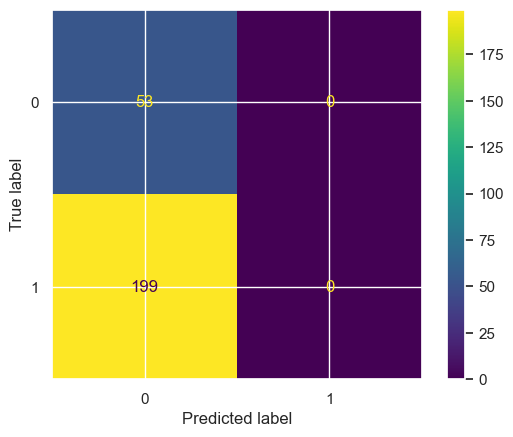

In [21]:
sma_pos_confmat = confusion_matrix(sma_y_test, sma_pos_pred)
sma_pos_confmat_dp = ConfusionMatrixDisplay(sma_pos_confmat)
sma_pos_confmat_dp.plot();

### EMA Model

In [22]:
ema_train_index = int(len(ema_stock_df) * 0.8)
ema_train = ema_stock_df[:ema_train_index]
ema_x_train = ema_train.drop(columns=['ema_signal', 'date'])
ema_y_train = ema_train['ema_signal']

ema_test = ema_stock_df[ema_train_index:]
ema_x_test = ema_test.drop(columns=['ema_signal', 'date'])
ema_y_test = ema_test['ema_signal']

print(f'''Shape of EMA Train: {ema_train.shape}
Shape of EMA X Train: {ema_x_train.shape}
Shape of EMA Y Train: {ema_y_train.shape}

Shape of EMA Test: {ema_test.shape}
Shape of EMA X Test: {ema_x_test.shape}
Shape of EMA Y Test: {ema_y_test.shape}''')

Shape of EMA Train: (1006, 11)
Shape of EMA X Train: (1006, 9)
Shape of EMA Y Train: (1006,)

Shape of EMA Test: (252, 11)
Shape of EMA X Test: (252, 9)
Shape of EMA Y Test: (252,)


#### Train the EMA RandomForestClassifier model

In [23]:
ema_randfor = RandomForestClassifier(n_jobs=-1, random_state=random_state)
ema_randfor.fit(X=ema_x_train, y=ema_y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

#### Test EMA RandomForestClassifier Model

In [24]:
ema_pos_pred = ema_randfor.predict(ema_x_test)
ema_randfor_accuracy = accuracy_score(ema_y_test, ema_pos_pred)
print(ema_randfor_accuracy)

0.20634920634920634


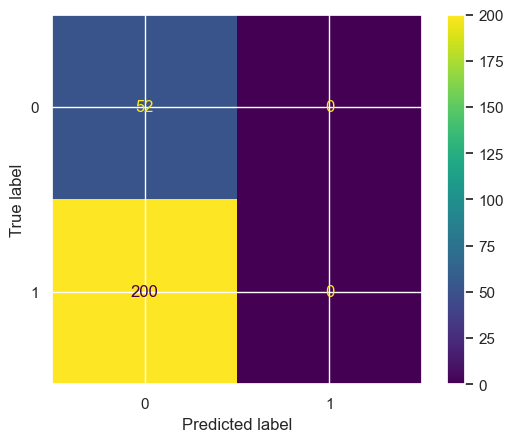

In [25]:
ema_pos_confmat = confusion_matrix(ema_y_test, ema_pos_pred)
ema_pos_confmat_dp = ConfusionMatrixDisplay(ema_pos_confmat)
ema_pos_confmat_dp.plot();

### MACD Model

In [26]:
macd_train_index = int(len(macd_stock_df) * 0.8)
macd_train = macd_stock_df[:macd_train_index]
macd_x_train = macd_train.drop(columns=['macd_bs_signal', 'date'])
macd_y_train = macd_train['macd_bs_signal']

macd_test = macd_stock_df[macd_train_index:]
macd_x_test = macd_test.drop(columns=['macd_bs_signal', 'date'])
macd_y_test = macd_test['macd_bs_signal']

print(f'''Shape of MACD Train: {macd_train.shape}
Shape of MACD X Train: {macd_x_train.shape}
Shape of MACD Y Train: {macd_y_train.shape}

Shape of MACD Test: {macd_test.shape}
Shape of MACD X Test: {macd_x_test.shape}
Shape of MACD Y Test: {macd_y_test.shape}''')

Shape of MACD Train: (1006, 11)
Shape of MACD X Train: (1006, 9)
Shape of MACD Y Train: (1006,)

Shape of MACD Test: (252, 11)
Shape of MACD X Test: (252, 9)
Shape of MACD Y Test: (252,)


#### Train the MACD RandomForestClassifier model

In [27]:
macd_randfor = RandomForestClassifier(n_jobs=-1, random_state=random_state, max_depth=5)
macd_randfor.fit(X=macd_x_train, y=macd_y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=1)

#### Test MACD RandomForestClassifier Model

In [28]:
macd_pos_pred = macd_randfor.predict(macd_x_test)
macd_randfor_accuracy = accuracy_score(macd_y_test, macd_pos_pred)
print(macd_randfor_accuracy)

0.5753968253968254


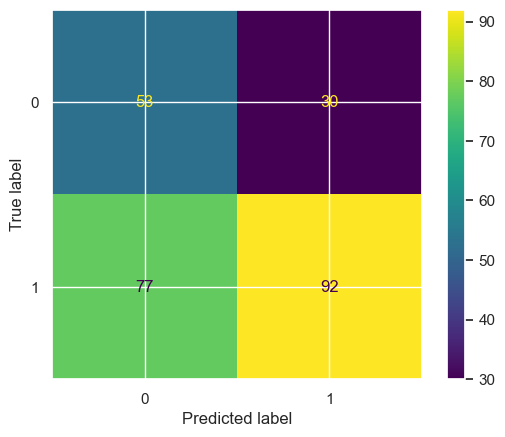

In [29]:
macd_pos_confmat = confusion_matrix(macd_y_test, macd_pos_pred)
macd_pos_confmat_dp = ConfusionMatrixDisplay(macd_pos_confmat)
macd_pos_confmat_dp.plot();